<a href="https://colab.research.google.com/github/ryderwishart/biblical-machine-learning/blob/main/syntax_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os

if 'biblical-machine-learning' not in [path for path in os.listdir()]:
    !git clone https://github.com/ryderwishart/biblical-machine-learning.git

Cloning into 'biblical-machine-learning'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 1406 (delta 75), reused 103 (delta 67), pack-reused 1284
Receiving objects: 100% (1406/1406), 72.72 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Updating files: 100% (1332/1332), done.


In [132]:
from pathlib import Path
from collections import defaultdict

file_paths = []
for path in Path("biblical-machine-learning/data/dependencies").glob("*.csv"):
    file_paths.append(os.path.abspath(path))

# Define a function to read the contents of a file
def read_lines(file_path):
    with open(file_path, "r") as f:
        lines = []
        for line in f:
            fields = line.strip().split('|')
            line_dict = defaultdict(str)
            id, form, head_id, func = fields[0:4]
            line_dict['morphgnt_id'] = id
            line_dict['morphgnt_head_id'] = head_id
            line_dict['function'] = func
            for field in fields[5:]:
                key, value = field.replace('"', '').split('=')
                line_dict[key] = value
            lines.append(line_dict)
        return lines

lines = []
for file_path in file_paths:
    for line in read_lines(file_path):
        lines.append(line)

import pandas as pd

frame = pd.DataFrame(lines)

subset_df = frame[frame['ref'].str.contains('2JN 1:1')]

In [133]:
subset_df.head(10)

,morphgnt_id,morphgnt_head_id,function,ref,Cat,Start,End,StrongNumber,UnicodeLemma,Gender,...,LexDomain,LN,Mood,Tense,Voice,SubjRef,Frame,Ref,Person,Degree
61579,63001001001,63001001002,det,2JN 1:1!1,det,0,0,3588,ὁ,Masculine,...,092004,92.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61580,63001001002,None,CL,2JN 1:1!2,adj,1,1,4245,πρεσβύτερος,Masculine,...,053009,53.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comparative
61581,63001001003,63001001004,adjp,2JN 1:1!3,adj,2,2,1588,ἐκλεκτός,Feminine,...,030006,30.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61582,63001001004,63001001002,IO,2JN 1:1!4,noun,3,3,2959,κυρία,Feminine,...,087003,87.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61583,63001001005,63001001004,conj,2JN 1:1!5,conj,4,4,2532,καί,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61584,63001001006,63001001007,det,2JN 1:1!6,det,5,5,3588,ὁ,Neuter,...,092004,92.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61585,63001001007,63001001004,np,2JN 1:1!7,noun,6,6,5043,τέκνον,Neuter,...,010002,10.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61586,63001001008,63001001007,np,2JN 1:1!8,pron,7,7,846,αὐτός,Feminine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n63001001004,NaN,NaN
61587,63001001009,63001001011,O,2JN 1:1!9,pron,8,8,3739,ὅς,Masculine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n63001001004 n63001001007,NaN,NaN
61588,63001001011,63001001004,CL,2JN 1:1!11,verb,9,9,25,ἀγαπάω,NaN,...,025003,25.43,Indicative,Present,Active,NaN,A1:n63001001009 A0:n63001001010;n63001001015;n...,NaN,First,NaN


In [139]:
import networkx as nx

selected_frame = frame

# Initialize an empty directed graph
G = nx.DiGraph()
labels = {}
# FIXME: make this into two loops to reduce order of complexity
# Iterate through the dataset rows and add nodes and edges
for index, row in selected_frame.iterrows():
    morphgnt_id = row['morphgnt_id']
    morphgnt_head_id = row['morphgnt_head_id']
    function = row['function']
    normalized_form = row['NormalizedForm']
    pos = row['Cat']
    labels[morphgnt_id] = normalized_form

    # Find head_id row in df
    head_rows = selected_frame[selected_frame['morphgnt_id'] == morphgnt_head_id]
    if len(head_rows) > 0:
        head_row = head_rows.iloc[0]
    # head_function = head_row['function']
    head_normalized_form = head_row['NormalizedForm']
    head_pos = head_row['Cat']

    # Add nodes for morphgnt_id and morphgnt_head_id if they don't exist
    if not G.has_node(morphgnt_id):
        G.add_node(morphgnt_id, type=pos, normalized_form=normalized_form, label=normalized_form)
    if not G.has_node(morphgnt_head_id):
        G.add_node(morphgnt_head_id, type=head_pos, label=head_normalized_form) # FIXME: this is the wrong label here

    # Add an edge between morphgnt_id and morphgnt_head_id with the 'function' as an attribute
    G.add_edge(morphgnt_id, morphgnt_head_id, label=function, function=function)



KeyboardInterrupt: ignored

In [96]:
# source_node = 'source_morphgnt_id'
# target_node = 'target_morphgnt_id'
# shortest_path = nx.shortest_path(G, source=source_node, target=target_node)
# print(shortest_path)


In [ ]:
print('Nodes: ', G.number_of_nodes())
print('Edges: ', G.number_of_edges())

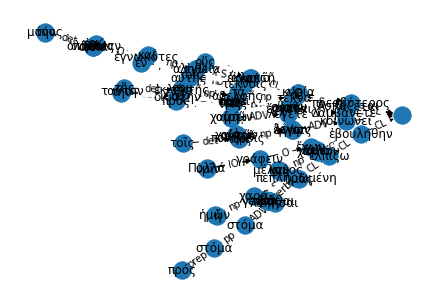

In [136]:
# import matplotlib.pyplot as plt

# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
# edge_labels = nx.get_edge_attributes(G, 'function')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.show()

import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(G)

# Create a dictionary that maps node IDs to their labels
# labels = {node_id: G.nodes[node_id]['label'] for node_id in G.nodes()}

# Draw the graph with node labels
nx.draw(G, pos, with_labels=True, labels=labels)

# Draw edge labels as before
edge_labels = nx.get_edge_attributes(G, 'function')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


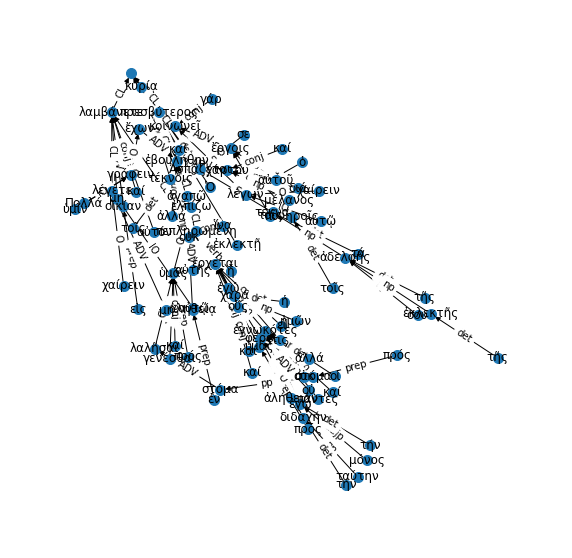

In [137]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)

# Set the figure size to 10x10 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph with node labels
nx.draw(G, pos, with_labels=True, labels=labels, ax=ax, node_size=100)

# Draw edge labels as before
edge_labels = nx.get_edge_attributes(G, 'function')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Avoid node overlap
plt.margins(0.1, 0.1)

plt.show()


In [ ]:
import lxml
output_file = "dep-graph-fullnt.graphml"
nx.write_graphml(G, output_file)
# If working locally, check os.getcwd() for file location.
# If working in Colab, click the 'files' sidebar button on the left.